In [0]:
!pip install unidecode
!python -m spacy download en_core_web_lg
# !python -m spacy download en_core_web_sm
# !pip install fbpca

# you have to restart your runtime after this cell

In [0]:
from google.colab import drive
drive.mount('/content/drive')

 The goal of this notebook was to search for top words of interest than can be associated to each news entry in column "HEADLINE_ALERT_TEXT", and at the same time attempting to cluster/topic model the docs in that column using Non Negative Matrix Factorization method.   
Why 4 topics?
My assumption was that if the entries in HEADLINE_ALERT_TEXT column are associated with only 4 unique entries in EVENT_TYPE column, then I can ask the same from my model in terms of clustering the news entries.
Non Negative Matrix Factorization method.   
A very fast, yet non unique solution to feature reduction of the TFIDF matrix to the number of topics/clusters that we think can represent all entries in HEADLINE_ALERT_TEXT column.

In [0]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
import codecs
import unidecode
import re
import string
import spacy
nlp = spacy.load('en_core_web_lg')
import nltk
nltk.download('punkt')
# import bs4 as bs
import urllib.request
from sklearn import decomposition
from scipy import linalg
# import fbpca

# Scrape from internet, and get the corpus of docs

In [0]:
# urlpathstr = 'https://whateveraddress...'

# def get_urldata(urlpath):
#   raw_html = urllib.request.urlopen(urlpath)
#   raw_html = raw_html.read()

#   doc_html = bs.BeautifulSoup(raw_html, 'lxml')
#   doc_html_paragraphs = doc_html.find_all('p')
#   docs = ''  # cleaned up text from all html stuff

#   for para in doc_html_paragraphs:
#       docs += para.text
#   return docs
# docs = get_urldata(urlpath= urlpathstr)

# corpus = nltk.sent_tokenize(docs) # doc objects, in this case they are sentences

## Get the dataframe
1- Choose the columns you want to work with, and a preliminary small subset of dataset  
2- Choose the text column for processing
 

In [0]:


df = pd.read_csv(r'/content/drive/My Drive/NLP/TR/working_folder/cleanSet.csv')
df.sort_values(by='DATE',inplace=True, ascending=True, axis=0)
df.dropna(inplace=True)
df = df.reset_index(drop=True)
df.reset_index(inplace=True)
l = ['DATE','TIME','STORY_DATE_TIME','EVENT_TYPE','HEADLINE_ALERT_TEXT', 'PRODUCTS', 'TOPICS','STORY_TYPE', 'TABULAR_FLAG']
df0 = pd.DataFrame(df[:20001], columns=df.columns)


In [5]:
df.shape

(235932, 13)

In [6]:
df0.shape

(20001, 13)

## Clean your text

In [0]:
from IPython.display import Markdown, display
# pd.set_option('display.max_colwidth', -1)
np.set_printoptions(suppress=True)
df0.iloc[0:20]['HEADLINE_ALERT_TEXT']

In [0]:
''' I borowed this contraction map and its cleaning function from a github page but I unfortunately I don't remember to whom it belongs to'''
contraction_mapping = {"<":"", ">":"", "--th":"", "sames":"same", "ain't": "am not", "aren't": "are not","can't": "cannot", "umm": "delicious",
                   "can't've": "cannot have", "'cuz": "because", "'cause": "because", "could've": "could have", 
                   "couldn't": "could not", "couldn't've": "could not have","didn't": "did not", 
                   "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
                   "hadn't've": "had not have", "hasn't": "has not", "haven't": "have not", 
                   "he'd": "he would", "he'd've": "he would have", "he'll": "he will", 
                   "he'll've": "he will have", "he's": "he is", "how'd": "how did", 
                   "how'd'y": "how do you", "how'll": "how will", "how's": "how is", 
                   "I'd": "I would", "I'd've": "I would have", "I'll": "I will", 
                   "I'll've": "I will have","I'm": "I am", "I've": "I have", 
                   "i'd": "i would", "i'd've": "i would have", "i'll": "i will", 
                   "i'll've": "i will have","i'm": "i am", "i've": "i have", 
                   "isn't": "is not", "it'd": "it would", "it'd've": "it would have", 
                   "it'll": "it will", "it'll've": "it will have","it's": "it is", 
                   "let's": "let us", "ma'am": "madam", "mayn't": "may not", 
                   "might've": "might have","mightn't": "might not","mightn't've": "might not have", 
                   "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", 
                   "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", 
                   "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
                   "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", 
                   "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", 
                   "she's": "she is", "should've": "should have", "shouldn't": "should not", 
                   "shouldn't've": "should not have", "so've": "so have","so's": "so as", 
                   "this's": "this is",
                   "that'd": "that would", "that'd've": "that would have","that's": "that is", 
                   "there'd": "there would", "there'd've": "there would have","there's": "there is", 
                       "here's": "here is",
                   "they'd": "they would", "they'd've": "they would have", "they'll": "they will", 
                   "they'll've": "they will have", "they're": "they are", "they've": "they have", 
                   "to've": "to have", "wasn't": "was not", "we'd": "we would", 
                   "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", 
                   "we're": "we are", "we've": "we have", "weren't": "were not", 
                   "what'll": "what will", "what'll've": "what will have", "what're": "what are", 
                   "what's": "what is", "what've": "what have", "when's": "when is", 
                   "when've": "when have", "where'd": "where did", "where's": "where is", 
                   "where've": "where have", "who'll": "who will", "who'll've": "who will have", 
                   "who's": "who is", "who've": "who have", "why's": "why is", 
                   "why've": "why have", "will've": "will have", "won't": "will not", 
                   "won't've": "will not have", "would've": "would have", "wouldn't": "would not", 
                   "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                   "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                   "you'd": "you would", "you'd've": "you would have", "you'll": "you will", 
                   "you'll've": "you will have", "you're": "you are", "you've": "you have" } 

def doc_cleaner0(doc):
    # doc = doc.lower() # convert to lower case
    # doc = re.sub("\s\d+", " ", doc) # remove undividual digits but not when inside a word
    # doc = re.sub(r'\W',' ', doc) # replace One non-word character with space
    # doc = re.sub(r'\s+',' ', doc) # replace one or more white space with a single space
    # doc = re.sub('\[.*?\]', '', doc) # ??
    # doc = re.sub('[%s]' % re.escape(string.punctuation), '', doc) # remove puctuations. this is a good one, but the problem is that it turns dates to numbers 
    # doc = re.sub('\w*\d\w*', '', doc) # removes pretty much any number
    doc = re.sub('[*.\--:‘’“”…]', '', doc) # remove these stuff too
    # doc = re.sub('\n', '', doc) # remove end of line char that probably was added during scraping or so.
    return doc

def doc_cleaner2(text):
    try:
        decoded = unidecode.unidecode(codecs.decode(text, 'unicode_escape'))
    except:
        decoded = unidecode.unidecode(text)
    apostrophe_handled = re.sub('[*<>.\--:‘’“”…]', '', decoded) #re.sub("’", "'", decoded)
    expanded = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in apostrophe_handled.split(" ")])
    parsed = nlp(expanded)
    final_tokens = []
    for t in parsed:
        if t.is_punct or t.is_stop or t.is_space or t.like_num or t.like_url or str(t).startswith('@'):
            pass
        else:
            if t.lemma_ == '-PRON-':
                final_tokens.append(str(t))
            else:
                sc_removed = re.sub("[^a-zA-Z]", '', str(t.lemma_))
                if len(sc_removed) > 1:
                    final_tokens.append(sc_removed)
    joined = ' '.join(final_tokens)
    spell_corrected = re.sub(r'(.)\1+', r'\1\1', joined)
    return spell_corrected


In [0]:
df0['Clean_HEADLINE_ALERT_TEXT'] = pd.DataFrame(df0['HEADLINE_ALERT_TEXT'].apply(lambda x: doc_cleaner2(x)))


In [10]:
df0.isnull().sum()

index                        0
DATE                         0
TIME                         0
UNIQUE_STORY_INDEX           0
EVENT_TYPE                   0
PNAC                         0
STORY_DATE_TIME              0
HEADLINE_ALERT_TEXT          0
PRODUCTS                     0
TOPICS                       0
STORY_TYPE                   0
TABULAR_FLAG                 0
LANGUAGE                     0
Clean_HEADLINE_ALERT_TEXT    0
dtype: int64

In [0]:
# df0.isna().sum()

In [11]:
df0['HEADLINE_ALERT_TEXT'][df0['Clean_HEADLINE_ALERT_TEXT']=='']

17301    ���������
Name: HEADLINE_ALERT_TEXT, dtype: object

In [0]:
# df0.drop([df0['Clean_HEADLINE_ALERT_TEXT']==''])
df0.drop(df0[df0['Clean_HEADLINE_ALERT_TEXT']==''].index, axis=0, inplace=True)

In [0]:
# df0.dropna(inplace=True)
# df0 = df0.reset_index(drop=True)

In [13]:
df0.shape

(20000, 14)

In [0]:
pd.set_option('display.max_colwidth', -1)
df0.iloc[0:20]['Clean_HEADLINE_ALERT_TEXT']

## Create the corpus of docs for generating the vocab dictionary

In [0]:
# in case one of your text columns is in list format you need to convert them to a string so TFIDF can work with it
# df['yourTextCol']=[" ".join(docList) for docList in df['yourTextCol'].values]
corpus = df0['Clean_HEADLINE_ALERT_TEXT'].apply(lambda item: nltk.sent_tokenize(item) )
corpus = [" ".join(docList) for docList in corpus.values]


In [0]:
min(corpus)

# Funtion to get tfidf matrix 
## this is a very slow code but is here just for reference to what a typical tfidf looked like  

In [0]:

def get_tfidfM(corpus):
  # cleaning is done already above using a separate function
  for i in range(len(corpus )):
      # corpus[i] = ''.join(map(str, corpus[i])) # you need to make this list-to-string mapping for tfidf to work with it
      corpus [i] = corpus [i].lower()
      corpus [i] = re.sub(r'\W',' ', corpus [i]) # replace One non-word character with space
      corpus [i] = re.sub(r'\s+',' ', corpus [i]) # replace one or more white space with a single space

  ##############################################################
  # create the corpus vocab (dictionary) and reduce it to the highest frequency terms
  ###########################################################

  dict_count = {}  # keys: unique token in corpus, values: its count in the corpus
  for item in corpus:                         # for every doc in corpus
      item_tokens = nltk.word_tokenize(item)  
      for token in item_tokens:               # for every token in tokenized doc
          if token not in dict_count.keys():  # if is not in dict, add it and count it as one
              dict_count[token] = 1  
          else:
              dict_count[token] += 1          # if the token already exists increment its count

  ##############################################################
  # decide how many token from your vocab you want to use 
  ###########################################################

  import heapq
  most_freq_tokens = heapq.nlargest(500, dict_count, key= dict_count.get)     # if your vocab is in dict format: keys and values
  # most_freq_tokens = heapq.nlargest(500, dict_count, key= lambda e:e[1])  # if you happend to make tuples of tokens and counts in a list, use this

  ##############################################################
  # create the idf dictionary of tokens and their idf score
  ###########################################################

  idf_score = {} # the keys: the token in vocab, the values: idf of that token, the list is the size of the # of docs
  for token in most_freq_tokens:   # go through every token in vocab
      doc_with_token = 0
      for item in corpus:           # go through every doc in corpus
          if token in nltk.word_tokenize(item):   # if vocab token is present in the doc(nomatter how many times) increment the count. do this for every doc
              doc_with_token += 1
      idf_score[token] = np.log(len(corpus)/(1 + doc_with_token))  # populate the idf dict with vocab token and its idf score, then move to the next token

  ##############################################################
  # create the tf dictionary: key: most freq word(filtered above), value: a list (of tf values in each doc, dim is # of docs)
  ###########################################################

  tf_score = {} # this will contain tokens of vocab, as keys. its value is a list of tf scores in each doc, dim is # of docs.
  for token in most_freq_tokens: # for every token in the new filtered vocab
      item_tf_vector = [] # each element in the list is the tf value of the word in the doc of the corpus that we are going to itterate below
      for item in corpus: # for every doc in corpus
          doc_freq = 0
          for word in nltk.word_tokenize(item):  # for every token in that doc
              if token == word:
                    doc_freq += 1   # increment the count for multiple occurances of the token in that doc
          word_tf = doc_freq/(len(nltk.word_tokenize(item))+1) # total counts of that token in that doc / num of tokens in that doc
          # word_tf = np.log((1+doc_freq)/(1+len(nltk.word_tokenize(item))))  # gives me negative values check it later why
          item_tf_vector.append(word_tf)  # this list correspond to one doc
      tf_score[token] = item_tf_vector # now every token in vocab becomes a key is tf_score dict and its value is the list of tf scores in every doc of corpus
  return tf_score, idf_score


In [0]:
%time tf_score, idf_score = get_tfidfM(corpus)

CPU times: user 38min 29s, sys: 466 ms, total: 38min 30s
Wall time: 38min 30s


In [0]:
print(tf_score.keys()) 

dict_keys(['news', 'update', 'test', 'ignore', 'share', 'say', 'alert', 'reuters', 'page', 'pct', 'june', 'price', 'buy', 'order', 'nyse', 'rating', 'imbalance', 'research', 'service', 'target', 'insider', 'stock', 'raise', 'jun', 'market', 'new', 'power', 'mln', 'inc', 'sell', 'bank', 'moody', 'result', 'company', 'india', 'bond', 'emea', 'bln', 'apac', 'north', 'amer', 'deal', 'gas', 'sale', 'fitch', 'china', 'euro', 'datum', 'fall', 'global', 'outlook', 'cut', 'rate', 'rise', 'oil', 'exchange', 'european', 'issue', 'low', 'high', 'america', 'group', 'open', 'energy', 'central', 'management', 'vs', 'pmi', 'bid', 'trade', 'index', 'corp', 'wealth', 'plant', 'financial', 'city', 'year', 'see', 'assign', 'europe', 'report', 'day', 'dollar', 'american', 'announce', 'daily', 'capital', 'offer', 'co', 'commodity', 'investment', 'gold', 'month', 'watch', 'general', 'ltd', 'firm', 'economy', 'stable', 'block', 'april', 'aa', 'hit', 'hold', 'asia', 'diary', 'gain', 'canada', 'icis', 'heren', 

### Populate the sparse matrix of tfidf scores. size: (size of vocab) X (# of docs)

In [0]:
tfidf_spars_M = [] # list(size:# of tokens in vocab) of lists(size:# of docs). each list is the tfidf score list for every token
for token in tf_score.keys():  
    tfidf_scores = []
    for tf_items in tf_score[token]:    # go through the every tf value in the list for each token, the size of each list is # of docs in corpus
        tfidf_score = tf_items * idf_score[token] # idf score for each token is only one value, is multiplied by every tf score associated to that token
        tfidf_scores.append(tfidf_score) # the list of tfidf scores for each token is appended to tfidf_scores list.
    tfidf_spars_M.append(tfidf_scores)   


### Convert tfidf matrix to an array, then transpose it to get the right size, then dataframe it

In [0]:
tf_idf_M = np.asarray(tfidf_spars_M)  # size: (size of vocab) X (# of docs)
# we need to transpose this to get a matrix of size (# of docs) X (size of vocab)

tf_idf_M = np.transpose(tf_idf_M)

tfidfM = pd.DataFrame(tf_idf_M, columns=tf_score.keys())


In [0]:
tfidfM.head(2)

In [0]:
tfidfM.T.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,19960,19961,19962,19963,19964,19965,19966,19967,19968,19969,19970,19971,19972,19973,19974,19975,19976,19977,19978,19979,19980,19981,19982,19983,19984,19985,19986,19987,19988,19989,19990,19991,19992,19993,19994,19995,19996,19997,19998,19999
news,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.681616,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.185895,0.0,0.0,0.681616,0.000000,0.000000,0.0,0.000000,0.0,0.681616,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.227205,0.0,0.0,0.0,0.681616,0.0,0.000000,0.0,0.0,0.0,0.255606,0.0,0.0,0.0,0.0,0.0,0.340808,0.0,0.511212,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
update,0.0,0.670048,0.335024,0.0,0.0,0.0,0.670048,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.446699,0.536038,0.0,0.0,0.0,0.0,0.0,0.382885,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.297799,0.335024,0.0,0.297799,0.0,0.000000,0.670048,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.335024,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.297799,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.297799,0.0


1- tfidfM: every row is a doc, with tfidf scores for every token in vocab  
2- tfidf.T : every row is a token with all its tfidf score across docs(cols)  
3- tfidfM.T[col].nlargest(n).index.tolist(): get the largest n scores in each col(ie each doc) get their index(i.e the tokens), put them in a list  
4- do this for every col  
n, col in enumerate(tfidfM.T): go through every row  
but now n is enumerate idex which is fine, as if it's representing every doc index  
5- at the end you have a dictionary of indexes(doc indexes) with a lst of top score words, you convert that to a dataframe.   
6- but you transpose it to get the same shape as your dataset  


In [0]:
d = pd.DataFrame({n: tfidfM.T[col].nlargest(4).index.tolist() for n, col in enumerate(tfidfM.T)}).T
d.head()


,0,1,2,3
0,emea,ignore,test,news
1,baseball,result,update,news
2,update,news,test,ignore
3,official,pmi,rise,china
4,ignore,test,news,update


In [0]:

d['Top Words'] = d[0].map(str) + ',' + d[1].map(str) + ',' + d[2].map(str) + ',' + d[3].map(str)
df0['HeadLineAlertTopWords'] = d['Top Words']

## if only require one top word just execute these lines
# highScore_word = tfidfM.idxmax(axis=1,skipna=True)
# df0['HeadLineAlertTopWord'] = highScore_word

In [0]:
pd.set_option('display.max_colwidth', 20)
df0.head(2)

In [0]:
df0.isnull().sum()

index                        0
DATE                         0
TIME                         0
UNIQUE_STORY_INDEX           0
EVENT_TYPE                   0
PNAC                         0
STORY_DATE_TIME              0
HEADLINE_ALERT_TEXT          0
PRODUCTS                     0
TOPICS                       0
STORY_TYPE                   0
TABULAR_FLAG                 0
LANGUAGE                     0
Clean_HEADLINE_ALERT_TEXT    1
HeadLineAlertTopWords        0
dtype: int64

In [0]:
df0.dropna(inplace=True)
df0 = df0.reset_index(drop=True)

In [0]:
df0.to_csv(r'/content/drive/My Drive/NLP/TR/working_folder/cleanSet_TFIDFFunc_topWord_1.csv', index=False)

# Much faster: Using tfidfVectorizer to extract top score words from docs in a particular col, for each row of dataset.    

## steps  
1- choose the text column   
2- process the text   
3- extract name entities and add them as a column to the df  
4- process tfidf scores on the text column,   
5- extract top tfidf score words for each doc and put them in a new column  
6- groupby date. do the above for timestep. in this case is a single day in the month of june  
7-   



In [0]:
df = pd.read_csv(r'/content/drive/My Drive/NLP/TR/working_folder/cleanSet_TFIDFFunc_topWord_1.csv')
# l = ['DATE','TIME','STORY_DATE_TIME','EVENT_TYPE','HEADLINE_ALERT_TEXT', 'PRODUCTS', 'TOPICS','STORY_TYPE', 'TABULAR_FLAG']
df0 = pd.DataFrame(df[:20000], columns=df.columns)
# print(df0.iloc[0:20]['HEADLINE_ALERT_TEXT'])
# df0.groupby('DATE').nunique()

In [0]:
del df

In [0]:
pd.set_option('display.max_colwidth', -1)

df0.iloc[0:20]['Clean_HEADLINE_ALERT_TEXT']

# Text processing
## To do this cleaning I need some knowledge of the text, especialy if it is broken english news pieces

# Lets use the preprocessed text from above for result comparison and consistency. The text cleaning process can be done differently if needed. at this point due to my limited knowledge of the text in the dataset this preprocessing might suffice.

In [0]:
df0.head(1)

In [0]:
# df0['HEADLINE_ALERT_TEXT'] = pd.DataFrame(df0['HEADLINE_ALERT_TEXT'].apply(lambda x: doc_cleaner2(x)))

In [0]:
pd.set_option('display.max_colwidth', -1)
df0.iloc[0:20]['Clean_HEADLINE_ALERT_TEXT']

### tfidf Vectorize your docs


In [0]:
cv = TfidfVectorizer(
        min_df=2, max_df=0.9, strip_accents='unicode',
        analyzer="word", token_pattern=r'\w{2,}', ngram_range=(1, 2),
        use_idf=1, smooth_idf=1, sublinear_tf=1 ,stop_words='english', lowercase=False, norm='l2')


In [23]:
# dtm = cv.fit_transform(df0['HEADLINE_ALERT_TEXT'])
dtm = cv.fit_transform(df0['Clean_HEADLINE_ALERT_TEXT']).todense()
print(dtm.shape)

(19999, 31311)


In [24]:
# vocab= cv.get_feature_names()
vocab= np.array(cv.get_feature_names())
len(vocab)

31311

## Full SVD decomposition of dtm matrix  .. This is very slow!!   
dtm = U . Sigma . Vtranspose  
the concept behind the use of SVD is that the factorized matrices, i.e., the decomposition matrices of U 

In [0]:
# %time U, s, Vh = linalg.svd(dtm, full_matrices=False) # s is suppossed to be a diagonal matrix but here the output is a vector. so use np.diag(s) to get its matrix

CPU times: user 4h 41min 52s, sys: 3min 29s, total: 4h 45min 21s
Wall time: 1h 12min 16s


# Truncated SVD   
Much faster. only focuses on the top value singular values. i.e., grabing the top clusters(topics)

In [25]:
%time u, s, v = decomposition.randomized_svd(M= dtm, n_components= 4)


CPU times: user 1min 19s, sys: 805 ms, total: 1min 20s
Wall time: 20.3 s


In [0]:
# print(U.shape, s.shape, Vh.shape)
print(u.shape, s.shape, v.shape)

### check the quality of your dtm decomposition

In [0]:
# reconstructed_dtm = U @ np.diag(s) @ Vh
reconstructed_dtm = u @ np.diag(s) @ v
np.allclose(reconstructed_dtm, dtm)

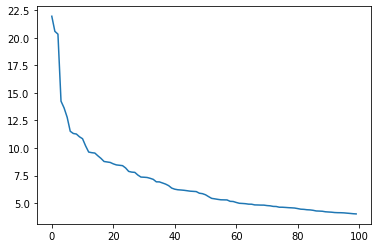

In [0]:
plt.plot(s[:100]) # the x axis are the topics and the y axis is the singular value in s matrix.

In [0]:
num_top_words=4

def show_topics(a):
    top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_top_words-1:-1]]
    topic_words = ([top_words(t) for t in a])
    return [','.join(t) for t in topic_words]

In [0]:
num_top_words=4

def get_ngrams(a):
    top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_top_words-1:-1]]
    topic_words = ([top_words(t) for t in a])
    return [','.join(t) for t in topic_words]

In [0]:
i=2
# get_ngrams(Vh[i:i+1])
get_ngrams(v[i:i+1])

['ORDER,IMBALANCE,ORDER IMBALANCE,NYSE ORDER']

In [0]:
# dftemp = pd.DataFrame({i: get_ngrams(Vh[i:i+1]) for i in range(Vh.shape[0])}).T
dftemp = pd.DataFrame({i: get_ngrams(v[i:i+1]) for i in range(v.shape[0])}).T


In [0]:
dftemp.head()

In [0]:
df0['SVDTop4Ngrams'] = dftemp

In [0]:
pd.set_option('display.max_colwidth', 30)
df0.head(1)

In [0]:
df0.to_csv(r'/content/drive/My Drive/NLP/TR/working_folder/cleanSet_TFIDFFuncTop4_SVDTop4.csv', index=False)

# Non_Negative Matrix Factorization

## NMF Clustering the text and extracting top words associated with the text but from perspective of its assignment to a particular cluster  

The concept here is to constrain our factorized matrices (from the original dataset with non-negative vaues, which docs or images are represented along columns of the dataset) to be non-negative. this facitilates intpretability of the scores.i.e.,  

 $$ V = W H$$  




In [0]:

df0 = pd.read_csv(r'/content/drive/My Drive/NLP/TR/working_folder/cleanSet_TFIDFFuncTop4_SVDTop4.csv')


In [0]:
df0.head(1)

In [0]:
df0.shape

(19999, 16)

In [0]:
# done already
# df0['Clean_HEADLINE_ALERT_TEXT'] = pd.DataFrame(df0['HEADLINE_ALERT_TEXT'].apply(lambda x: doc_cleaner2(x)))


In [0]:
cv = TfidfVectorizer(
        min_df=2, max_df=0.9, strip_accents='unicode',
        analyzer="word", ngram_range=(1, 2), # token_pattern=r'\w{2,}',
        use_idf=1, smooth_idf=1, sublinear_tf=1 ,stop_words='english', lowercase=False, norm='l2')

dtm = cv.fit_transform(df0['Clean_HEADLINE_ALERT_TEXT']).todense()


In [0]:
dtm.shape

(19999, 31311)

In [0]:

vocab= np.array(cv.get_feature_names())
len(vocab)

31311

In [0]:
n= df0['EVENT_TYPE'].nunique()
nmf_model = NMF(n_components=n, random_state=101)
nmf_model.fit(dtm)

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
    n_components=4, random_state=101, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

In [0]:
# for index,topic in enumerate(nmf_model.components_):
#     print(f'Top score word/phrases in cluster #{index}')
#     print([cv.get_feature_names()[i] for i in topic.argsort()[-4:][::-1]])
#     print('\n')

In [0]:
topngrams = []
for index,topic in enumerate(nmf_model.components_):
    topngrams.append([cv.get_feature_names()[i] for i in topic.argsort()[-4:][::-1]])


In [0]:
topngrams

[['test ignore', 'test', 'ignore', 'ignore EMEA'],
 ['Page', 'NEWS Page', 'NEWS', 'NEWS energy'],
 ['ORDER', 'IMBALANCE', 'ORDER IMBALANCE', 'NYSE ORDER'],
 ['news', 'company', 'news company', 'commodity']]

In [0]:
topic_results = nmf_model.transform(dtm)
topic_results

array([[1.56230345e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.13160390e-06, 1.74070943e-06, 8.92645797e-05, 1.36321878e-04],
       [6.49379815e-06, 3.29113744e-06, 2.13574285e-05, 3.36933094e-05],
       ...,
       [1.92337973e-05, 7.39956171e-06, 1.22786362e-02, 1.72274726e-04],
       [1.62334103e-05, 9.44907125e-05, 9.73593221e-05, 1.29731544e-04],
       [5.24547513e-07, 1.87949151e-06, 1.46143179e-05, 1.41296367e-05]])

In [0]:
df0['NMFCluster#'] = topic_results.argmax(axis=1)
cluster_map = {0: 'cluster_1', 1: 'cluster_2', 2: 'cluster_3', 3: 'cluster_4'}
df0['Headline_Topic_NMF'] = df0['NMFCluster#'].map(cluster_map)

In [0]:
df0.head(2)

In [0]:
df0['NMFTop4ngrams'] = df0['NMFCluster#'].apply(lambda i: topngrams[i] )

In [0]:
df0.head(1)

In [0]:
df0.to_csv(r'/content/drive/My Drive/NLP/TR/working_folder/cleanSet_TFIDFFuncTop4_SVDTop4_NMFTop4.csv',index=False)

## Extract top score ngrams using tfidfVectorizer from above 

In [0]:
d1 = pd.DataFrame(dtm, columns=vocab)

In [0]:
d1.head(1)

In [0]:
d = pd.DataFrame({n: d1.T[col].nlargest(4).index.tolist() for n, col in enumerate(d1.T)}).T
d.head()

In [0]:

d['TopTFIDFngrams'] = d[0].map(str) + ',' + d[1].map(str) + ',' + d[2].map(str) + ',' + d[3].map(str)
df0['TopTFIDFngrams'] = d['TopTFIDFngrams']

In [0]:
df0.head(2)

In [0]:
df0.to_csv(r'/content/drive/My Drive/NLP/TR/working_folder/cleanSet_TFIDFFuncTop4_SVDTop4_NMFTop4_TFIDFTop4.csv',index=False)

## Examine the group by DATE documents

In [0]:
pd.set_option('display.max_colwidth', 40)

In [0]:
df0 = pd.read_csv(r'/content/drive/My Drive/NLP/TR/working_folder/cleanSet_TFIDFFuncTop4_SVDTop4_NMFTop4_TFIDFTop4.csv')
# df0 = pd.read_csv(r'/content/drive/My Drive/NLP/TR/working_folder/cleanSet_TFIDFFuncTop4_SVDTop4_NMFTop4.csv')

In [0]:
df0.sort_values(by='DATE',inplace=True, ascending=True, axis=0)
df0.reset_index(inplace=True)

In [0]:
# df.sort_values(by='DATE',inplace=True, ascending=True, axis=0)
# df.reset_index(inplace=True)
# l = ['DATE','TIME','STORY_DATE_TIME','EVENT_TYPE','HEADLINE_ALERT_TEXT', 'PRODUCTS', 'TOPICS','STORY_TYPE', 'TABULAR_FLAG']
df2 = pd.DataFrame(df0, columns=df0.columns)


In [0]:
df_grouped = pd.DataFrame(df2.groupby(['DATE'])['EVENT_TYPE'].apply(lambda item: ". ".join(item)),columns=['EVENT_TYPE'])
df_grouped['HEADLINE_ALERT_TEXT'] = df2.groupby(['DATE'])['HEADLINE_ALERT_TEXT'].apply(lambda item: ". ".join(item))
df_grouped['PRODUCTS'] = df2.groupby(['DATE'])['PRODUCTS'].apply(lambda item: ". ".join(item))
df_grouped['TOPICS'] = df2.groupby(['DATE'])['TOPICS'].apply(lambda item: ". ".join(item))


In [0]:
df_grouped.shape

(4, 4)

In [0]:
df_grouped.to_csv(r'/content/drive/My Drive/NLP/TR/working_folder/cleanSet_GroupByDate.csv',index=True)

In [0]:
df_grouped= pd.read_csv(r'/content/drive/My Drive/NLP/TR/working_folder/cleanSet_GroupByDate.csv')

In [0]:
df2 = pd.DataFrame(df_grouped[:], columns=df_grouped.columns)

In [0]:
df2.head(1)

In [0]:
df_grouped['Clean_HEADLINE_ALERT_TEXT'] = pd.DataFrame(df2['HEADLINE_ALERT_TEXT'].apply(lambda x: doc_cleaner2(x)))

In [0]:
df_grouped.head(2)

In [0]:
cv = TfidfVectorizer(
        min_df=2, max_df=0.9, strip_accents='unicode',
        analyzer="word", ngram_range=(1, 2), # token_pattern=r'\w{2,}',
        use_idf=1, smooth_idf=1, sublinear_tf=1 ,stop_words='english', lowercase=False, norm='l2')

In [0]:
dtm = cv.fit_transform(df_grouped['Clean_HEADLINE_ALERT_TEXT']).todense()

In [0]:
vocab= np.array(cv.get_feature_names())
len(vocab)

8889

In [0]:
d1 = pd.DataFrame(dtm, columns=vocab)

In [0]:
dtemp = pd.DataFrame({n: d1.T[col].nlargest(4).index.tolist() for n, col in enumerate(d1.T)}).T
dtemp.head()

In [0]:
dtemp.shape

(4, 4)

In [0]:
df_grouped['TopHeadLineAlertDateGroupByngrams'] = dtemp[0].map(str) + ', ' + dtemp[1].map(str) + ', ' + dtemp[2].map(str) + ', ' + dtemp[3].map(str)
# df0['TopTFIDFngrams'] = d['TopTFIDFngrams']

In [0]:
df_grouped.head(4)

In [0]:
df_grouped.to_csv(r'/content/drive/My Drive/NLP/TR/working_folder/cleanSet_GroupByDate_HEADLINE_ALERT_TEXT_TOPngrams.csv',index=False)

In [0]:
df= pd.read_csv(r'/content/drive/My Drive/NLP/TR/working_folder/cleanSet_GroupByDate_HEADLINE_ALERT_TEXT_TOPngrams.csv')

In [0]:
df.head()

# Still In progress 
Another approach

In [0]:
df = pd.read_csv(r'/content/drive/My Drive/NLP/TR/working_folder/cleanSet.csv')
df.dropna(inplace=True)
df.sort_values(by='DATE',inplace=True, ascending=True, axis=0)


In [0]:
df.shape

(235932, 12)

In [0]:
# df.reset_index(inplace=True)
# l = ['DATE','TIME','STORY_DATE_TIME','EVENT_TYPE','HEADLINE_ALERT_TEXT', 'PRODUCTS', 'TOPICS','STORY_TYPE', 'TABULAR_FLAG']
df0 = pd.DataFrame(df[:20001], columns=df.columns)
df0['Clean_HEADLINE_ALERT_TEXT'] = pd.DataFrame(df0['HEADLINE_ALERT_TEXT'].apply(lambda x: doc_cleaner2(x)))
del df

In [0]:
df0.isnull().sum()
# df0.isna() # These two methods are the same for pd dataframes, they look diff cuz they originated from R, but pd built on numpy looks for Nans using eaither of these

DATE                         0
TIME                         0
UNIQUE_STORY_INDEX           0
EVENT_TYPE                   0
PNAC                         0
STORY_DATE_TIME              0
HEADLINE_ALERT_TEXT          0
PRODUCTS                     0
TOPICS                       0
STORY_TYPE                   0
TABULAR_FLAG                 0
LANGUAGE                     0
Clean_HEADLINE_ALERT_TEXT    0
dtype: int64

In [0]:
df0['HEADLINE_ALERT_TEXT'][df0['Clean_HEADLINE_ALERT_TEXT']=='']


221582    ���������
Name: HEADLINE_ALERT_TEXT, dtype: object

In [0]:
df0.drop(df0[df0['Clean_HEADLINE_ALERT_TEXT']==''].index, axis=0, inplace=True)
df0.reset_index(inplace=True)

In [0]:
df0.head(1)

In [0]:
df0.drop(['index'], inplace=True, axis=1) # 'level_0' and possibly other self-generated indexes

In [0]:
df0.head(1)

In [0]:
cv = TfidfVectorizer(
        min_df=20, max_df=0.30, strip_accents='unicode',
        analyzer="word", ngram_range=(1, 2), # token_pattern=r'\w{2,}',
        use_idf=1, smooth_idf=True, sublinear_tf=True ,stop_words='english', lowercase=False, norm='l2') # tf scaling, i.e. replace tf with 1 + log(tf)

dtm = cv.fit_transform(df0['Clean_HEADLINE_ALERT_TEXT'])#.todense() I'm not using this here. later I convert my dtm to nd array

# min_df=2 requires that an ngram appear in atleast 2 of the docs in order to be considered part of the vocab, or to limit the size of vocab
# max_df= 0.90 : exclude ngrams that are too frequent, i.e., we consider them less important
# strip_accents='unicode': removes accents and perform other character normalization during the preprocessing step
# todense() retunrs a matrix from the spars transformation, toarray() returns an np array
# fit_transform: Learn vocabulary and idf, return term-document matrix.
# smooth_idf=1: adding 1 makes the tokens/ngrams occuring in all docs will not be entirely ignored
# sublinear_tf=True: replace tf with 1 + log(tf).

In [0]:
vocab= np.array(cv.get_feature_names())
len(vocab)

1441

In [0]:
print(dtm.shape)
print(vocab.shape)

(20000, 1441)
(1441,)


In [0]:
row_indx = 0
# np.squeeze(dtm[row_indx])

In [0]:
def top_tfidf_ngrams(densdtm, vocab, top_n): # this func will be called later by the return of another func where densdtm is defined and passed to it
    ''' Get top n tfidf scores in densdtm and return them with their corresponding ngrams'''
    topn_indx = np.argsort(densdtm)[::-1][:top_n] # argsort sorts(whether it actualy does it or not) the vals in ascending order then returns their indices
    top_ngrams = [(vocab[i], densdtm[i]) for i in topn_indx] # list of tuples of ngrams and their scores (just the top_n ones)
    df = pd.DataFrame(top_ngrams, columns=['ngram', 'tfidf'])
    return df

In [0]:
# def top_ngrams_ina_single_doc(dtm, vocab, row_indx=0, top_n=8):
#     ''' Top tfidf ngrams in  doc '''
#     densdtm = np.squeeze(dtm[row_indx].toarray())
#     # densdtm = dtm[row_indx].toarray()
#     return top_tfidf_ngrams(densdtm, vocab, top_n)

In [0]:
# d = top_ngrams_ina_single_doc(dtm, vocab, row_indx=0, top_n=8)
# d.shape

(8, 2)

In [0]:
D = dtm.toarray()
tfidf_threshold=0.02
D[D < tfidf_threshold] = 0  # filter out ngrams with scores lower than threshold tfidf_threshold
tfidf_means = np.mean(D, axis=0) 

In [0]:
tfidf_means.shape

(31311,)

In [0]:
tfidf_means.max()

0.02607074639070489

In [0]:
def top_mean_ngrams(dtm, vocab, ids=None, tfidf_threshold=0.02, top_n=4):
    ''' dtm is converted to nd array, tfidf mean of ngrams across all docs computed, passed to another func to get 
    the argsort index of top_n ngrams and their scores, a list of tuple of ngrams and their scores created, a df created of it, and done ''' 
    if ids:
        D = dtm[ids].toarray()
    else:               # if ids=None, means all docs (rows) will be considered
        D = dtm.toarray()

    D[D < tfidf_threshold] = 0  # filter out ngrams with scores lower than threshold tfidf_threshold
    tfidf_means = np.mean(D, axis=0)  # this mean is not dominated by high freq low importance(tfidf) words like "a", "the"
                                      # axis 0 for a 2d array is vertically down, i.e., along columns
    return top_tfidf_ngrams(tfidf_means, vocab, top_n)

In [0]:
top_mean_ngrams(dtm=dtm, vocab=vocab, ids=None, tfidf_threshold=0.025, top_n=4)


,ngram,tfidf
0,NEWS,0.027341
1,test,0.024876
2,ignore,0.023807
3,test ignore,0.021553


In [0]:
ytr = np.unique(df0['EVENT_TYPE'])
df0['EVENT_TYPE'].value_counts()

STORY_TAKE_OVERWRITE    8296
HEADLINE                8209
ALERT                   2726
STORY_TAKE_APPEND        769
Name: EVENT_TYPE, dtype: int64

In [0]:
ytr

array(['ALERT', 'HEADLINE', 'STORY_TAKE_APPEND', 'STORY_TAKE_OVERWRITE'],
      dtype=object)

In [0]:
def top_ngrams_by_class(dtm, ytr, vocab, tfidf_threshold=0.1, top_n=8):
    ''' Return a list of dataframes, where each df holds top_n ngrams and their mean tfidf score computed for all docs with the same class label. '''
    class_ngram_dfs = []
    labels = np.unique(ytr)
    for label in labels:
        ids = np.where(ytr==label)
        feats_df = top_mean_ngrams(dtm, vocab, ids, tfidf_threshold= tfidf_threshold, top_n= top_n)
        feats_df.label = label
        class_ngram_dfs.append(feats_df)
    return class_ngram_dfs


In [0]:
class_ngram_dfs= top_ngrams_by_class(dtm=dtm, ytr=ytr, vocab=vocab, tfidf_threshold=0.2, top_n=4)


In [0]:
len(class_ngram_dfs)

4

In [0]:
def plot_tfidf_classngram_barChart(class_ngram_dfs):
    ''' Plot the data frames returned by the function top_ngrams_by_class(). '''
    fig = plt.figure(figsize=(18, 6), facecolor="w")
    x = np.arange(len(class_ngram_dfs[0]))
    for i, df in enumerate(class_ngram_dfs):
        ax = fig.add_subplot(1, len(class_ngram_dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Ave Tf-Idf Score", labelpad=16, fontsize=14)
        ax.set_title("Ylabel = " + str(df.label), fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df['tfidf'], align='center', color='#3F5D7D')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df['ngram'])
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.show()


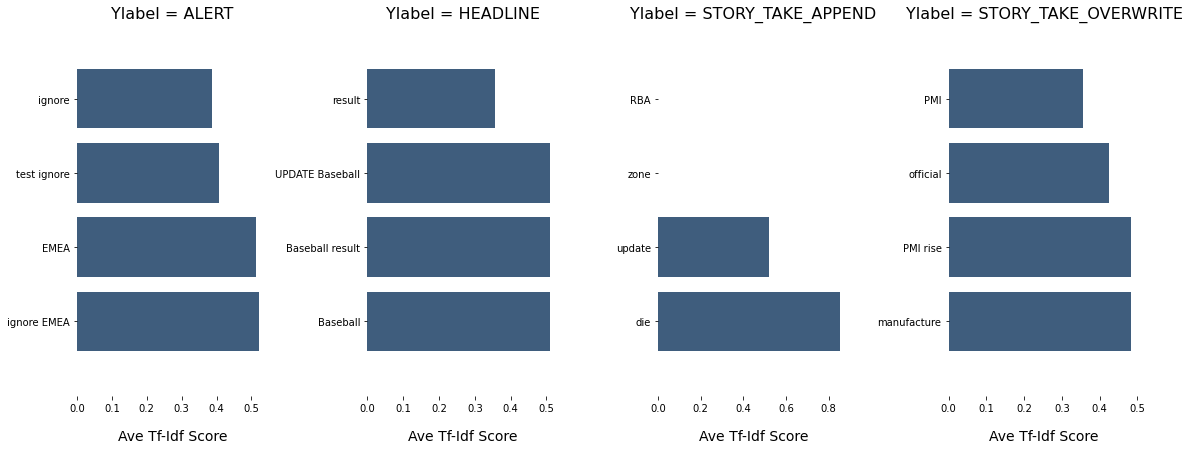

In [0]:
plot_tfidf_classngram_barChart(class_ngram_dfs[0:4])
